# Signature Verification using Siamese Neural Networks
Based on https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch
## Setup
Installing missing libraries

In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

tcmalloc: large alloc 1073750016 bytes == 0x58bca000 @  0x7f5395a622a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 5.7MB 6.1MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


Importing libraries

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import PIL.ImageOps  
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
from google.colab import drive
from PIL import Image, ImageOps
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset

Mounting Google Drive to get access to the training and test data. The data should be on this user's Google Drive. To get access to the data, visit http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2011_Signature_Verification_Competition_(SigComp2011), reorganize the data to look as follows and then upload it to your Google Drive.

For real data:

*Data/signatures/training/{id}/image.png*

*Data/signatures/testing/{id}/image.png*

For fake data:

*Data/signatures/training/F{id}/image.png*

*Data/signatures/testing/F{id}/image.png*

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Helper functions
Set of helper functions

In [0]:
def imshow(img, text=None, should_save=False):
    """Displays an image.

    Args:
      img: The image to be displayed
    """
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration, loss, points=None, strX="", strY=""):
  """Displays a plot based on iteration and loss.

  Args:
    iteration: The iteration
    loss: The loss
  """
  plt.plot(iteration,loss)
  if points:
    plt.xlabel(strX)
    plt.ylabel(strY)
    plt.plot(iteration,loss, marker='o')
    
  plt.show()

## Configuration Class
A simple class to manage configuration

In [0]:
class Config():
    training_dir = "/content/gdrive/My Drive/Data/signatures/training/"
    testing_dir = "/content/gdrive/My Drive/Data/signatures/testing/"
    train_batch_size = 64
    train_number_epochs = 10

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [0]:
class SiameseNetworkDataset(Dataset):
    """Dataset to be used with a Siamese Neural Network.
    
    """
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        self.files = {}
        self.img_tuples = []
        
        # Saving to a dictionary so that we can later match real signatures with their respective fake.
        for el, _ in imageFolderDataset.imgs:
          f_id = self.__get_folder_id(el)
          if f_id in self.files:
            self.files[f_id].append(el)
          else:
            self.files[f_id] = [el]
        
        # Matching real signatures with their respective fake.
        for key in self.files:
          if key[0] == 'F':
            continue
          for file1 in self.files[key]:
            for file2 in self.files[key]:
              if file1 != file2:
                self.img_tuples.append((file1, file2, 1))
            for file2 in self.files["F" + key]:
              self.img_tuples.append((file1, file2, 0))       
                
    def __get_folder_id(self, s):
      """Returns the folder id based on the image path.
      
      """
      s1 = s
      j = s1.rfind('/')
      s2 = s1[:j]
      i = s2.rfind('/')
      return s[i + 1:j]

    def __pad_image(self, desired_size, im):
      """Creates a new image and pastes the image passed as argument in the
      center so that they all have the same size.
      
      """
      old_size = im.size
      ratio = float(desired_size)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])
      im = im.resize(new_size, Image.ANTIALIAS)
      color =(255,255,255,0)
      if self.should_invert:
        color = (0,0,0,0)
        
      new_im = Image.new("RGB", (desired_size, desired_size), color=color)
      new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
      return new_im
    
    def __getitem__(self, index):
        img0 = Image.open(self.img_tuples[index][0])
        img1 = Image.open(self.img_tuples[index][1])
        
        # Getting the image negative
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
        
        # Padding the image so they all have a similar size.
        img0 = self.__pad_image(200, img0)
        img1 = self.__pad_image(200, img1)

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([self.img_tuples[index][2]], dtype=np.float32))
    
    def __len__(self):
        return len(self.img_tuples)

## Using Image Folder Dataset

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform=transforms.Compose([transforms.ToTensor()]), should_invert=True)
print(siamese_dataset.__len__())

8410


## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

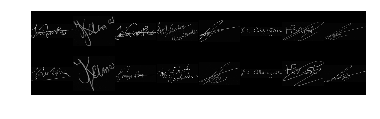

[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [0]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=8)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [0]:
class SiameseNetwork(nn.Module):
  """A Siamese Neural Network.

  """
  def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            #nn.Conv2d(1, 4, kernel_size=8),
            #nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            #nn.Conv2d(4, 8, kernel_size=5),
            #nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            #nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8)
        )

        self.dropout = nn.Dropout()
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*200*200, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

  def forward_once(self, x):
        output = self.dropout(self.cnn1(x))
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

  def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [0]:
class ContrastiveLoss(torch.nn.Module):
  """Contrastive loss function.
  
  Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
  """

  def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

  def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Training

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=Config.train_batch_size)
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

This piece of code allows us to use the GPU if there is one available.

In [0]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print("Using CUDA")
else:
    print("Using CPU")

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs")
  net = nn.DataParallel(net)
  
net.to(device)

Using CUDA


SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5)
  (fc1): Sequential(
    (0): Linear(in_features=320000, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            
        model_file = 'model_' + str(epoch) + '.pth'
        torch.save(net.state_dict(), model_file)

In [0]:
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [0]:
# Comment this to load a model and avoid training
#net.load_state_dict(torch.load("/content/gdrive/My Drive/Data/model_2.pth"))

In [0]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transforms.Compose([transforms.ToTensor()]),should_invert=True)

Some random samples

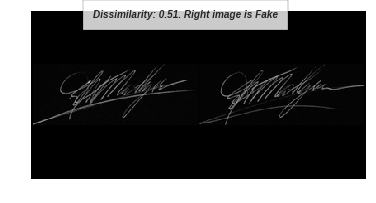

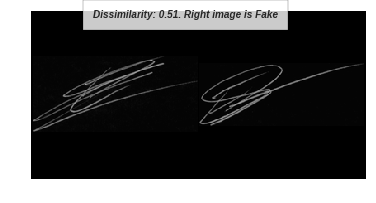

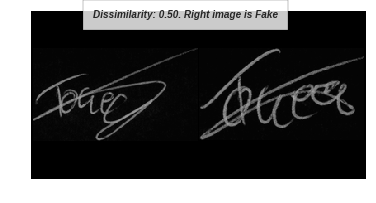

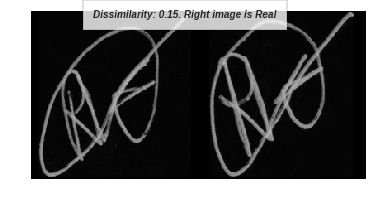

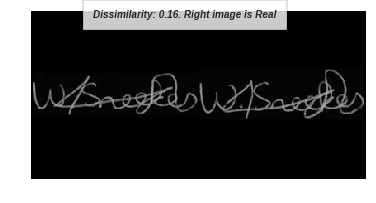

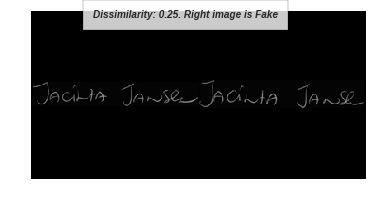

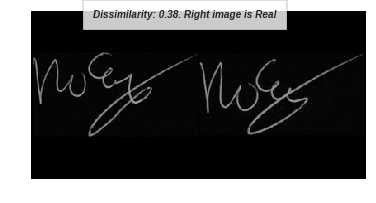

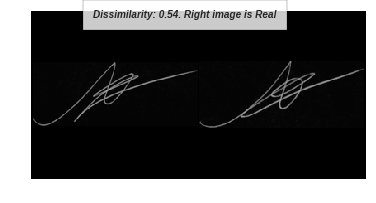

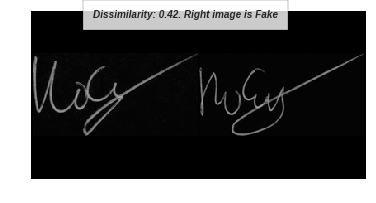

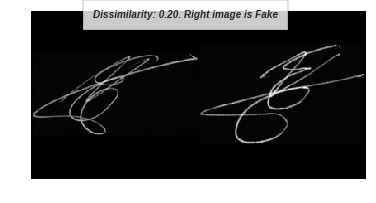

In [0]:
test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
for i in range(10):
    x0,x1,label2 = next(dataiter)
    label3 = "Real" if label2[0][0] == 1 else "Fake"
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}. Right image is {:}'.format(euclidean_distance.item(), label3))

In [0]:
test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=False)
#x0,_,_ = next(dataiter)

thresholds = [0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34]
tpr = []
fpr = [] #far
frr = []
accuracy = []

for threshold in thresholds:
  dataiter = iter(test_dataloader)
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  p = 0
  n = 0
  acc = 0
  total =  len(dataiter) #100
  for i in range(total):
    x0,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    predicted_label = 0
    if euclidean_distance < threshold:
      # Classify as True
      predicted_label = 1
      if label2[0][0] == 1:
        tp += 1
      else:
        fp += 1
    else:
      # Classify as False
      if label2[0][0] == 0:
        tn += 1
      else:
        fn += 1
      
    if label2[0][0] == predicted_label:
      acc += 1

    if label2[0][0] == 1:
      p += 1
    else:
      n += 1
      
  acc /= total
  tpr.append(tp/p)
  fpr.append(fp/n)
  frr.append(fn/(tp + fn)) #fnr
  accuracy.append(acc)
  print('A : ',accuracy,'tpr : ',tpr,'fpr : ',fpr, 'frr : ',frr)
print(tpr)
print(fpr)
print(frr)
print(accuracy)

ROC

In [0]:
show_plot(fpr, tpr, thresholds, "False Positive Rate", "True Positive Rate")

In [0]:
show_plot(frr, far, thresholds, "False rejection rate", "False acceptance rate")
